# Disclaimer

This is my solution to the Cohere for AI Scholars take-home test in 2023 September.

TLDR; The task was to debug a custom BERT model and then use it for sentence embeddings, fine-tuning it in various ways. Most of the functions I have written, other than the BERT model, which I just debugged.

# **Background**

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of different challenges including:

*   Identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
*   Testing your ability to generate code for a specified problem.
*   An opportunity for you to attempt an optional challenge question that extends the original problem set.

These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources (can be run in this colab).

Good luck!

**How to Use and Submit this Document?**

*   **Make a copy of this document** and rename it **Firstname_Lastname_C4AIScholarsChallenge**
*   Once you have completed all tasks, save and pin your revisions
*   Submit the assignment by responding directly to the email you received (please reply all) with a link to your final document by Friday September 29th at 12pm PDT.

# **Universal sentence embeddings background [2 points]**
In this takehome, we will be exploring different ways of learning sentence embeddings. Sentence embedding is the collective name for a set of techniques in natural language processing (NLP) where sentences are mapped to vectors of real numbers. For an overview of sentence embeddings and some common methods, we refer these articles: [link1](https://txt.cohere.com/sentence-word-embeddings/), [link2](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a)  

Q1: What are some real world applications of dense sentence embeddings?

Answer: There are many applications in NLP tasks of sentence embeddings, these could include semantic similarity, summarisation, text classification, sentiment analysis or machine translation. More concretely, for example, sentence embeddings are crucial for sentiment analysis of product reviews. An example in text classification is categorising emails to find spams.

Q2: Apart from using large language models, what are other ways to compute sentence embeddings?

Answer: One simple example is bag of words, where a sentence is represented by a set of its words. Another is Doc2Vec, which is an extension of Word2Vec, where the order of words are learnt and it can generate embeddings for sentences of or documents. There are many other, though, for example InferSent, Skip-Thought Vectors or FastText.

**Imports**

In [ ]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
%pip install transformers
from transformers import AutoTokenizer
# If you can not find all the bugs, use the line below for AutoModel
#from transformers import AutoModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.4 MB/s eta 0:00:00


## **Coding Challenge Part 1: Debugging custom BERT code [7 points]**

BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)) is a transformer based language model that is pretrained to generate contextualized embeddings. In this part, we provide a BERT implementation together with a pretrained checkpoint file. This BERT implementation includes 7 bugs in which some of these bugs break the code but some of them only impact the model performance.

Tasks:
* [**7 points**] Your goal is to get the code working. There are 7 bugs in the code, some of them lead to error in the code but some of them are designed to impair test accuracy but not break the code. You will one point for each of the 7 bugs you find.

* [**1 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.


Note for usage and comparison:
*   In order to test this implementation, we provide ***bert_tiny.bin*** and example usage in the below cells.
*   You can check if your bugfixes are correct based on your results in "Coding challenge Part 2". Except the Bert imlementation, there is no bugs in other parts, so if your fixes are correct you should achieve the same results. We provide the expected results for you to compare.


**Please DO NOT use any additional library except the ones that are imported!!**

In [ ]:
"""
I have added comments on the right hand side to describe the bugs that I have found.
"""

def gelu(x):
    """
    Gaussian error linear unit activation function
    """

    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class Config(object):

    def __init__(self,
                vocab_size,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                dropout_prob=0.1,                                                               # bug1: dropout = 0.9 is too high! changed it to dropout=0.1
                max_position_embeddings=512,
                type_vocab_size=2,
                initializer_range=0.02):
        """
        configuration class for the BERT model.
        this class stores various hyperparameters and settings required for initializing the model.
        :param vocab_size: size of vocabulary
        :param hidden_size: size of hidden layers in transformers
        :param num_hidden_layers: number of hidden layers in the transformer encoder
        :param num_attention_heads: number of attention heads for multihead attention
        :param intermediate_size: size of intermediate layer
        :param dropout_prob: dropout probability
        :param max_position_embeddings: maximum number of tokens allowed
        :param type_vocab_size: the vocabulary size of the token type IDs
        :param initializer_range: the standard deviation of the initializer for weight matrices
        """
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object):
        """
        creates a config object from a dictionary.
        :param dict_object: dictionary containing the configuration parameters.
        :return: Config object.
        """
        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config


class LayerNorm(nn.Module):
      def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

      def forward(self, x):
        u = x.mean(-1, keepdim=True)                                                            # bug2: dimension of mean should be -1, not 1
        s = (x - u).pow(2).mean(-1, keepdim=True)                                               # bug3: (x-u) instead of (x+u)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta


class MLP(nn.Module):
      def __init__(self, hidden_size, intermediate_size):
        super(MLP, self).__init__()
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, x):
        x = self.dense_expansion(x)
        x = self.dense_contraction(gelu(x))
        return x


class Layer(nn.Module):
    def __init__(self, config):
        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        self.ln1 = LayerNorm(config.hidden_size)

        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor, num_heads, attention_head_size):
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor, num_heads, attention_head_size):
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        return tensor.view(new_shape)

    def attn(self, q, k, v, attention_mask):
        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)

        s = torch.matmul(q, k.transpose(2,3))                                                   # bug4: need to take the transpose of k
        s = s / math.sqrt(self.attention_head_size)

        s = torch.where(mask, s, -torch.tensor(float('inf')))                                   # bug5: this should be -inf, not inf

        p = F.softmax(s, dim=-1)                                                                # bug6: there should be a softmax here
        p = self.dropout(p)

        a = torch.matmul(p, v)
        return a

    def forward(self, x, attention_mask):
        q, k, v = self.query(x), self.key(x), self.value(x)

        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size)
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

        a = self.attn(q, k, v, attention_mask)
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)
        a = self.attn_out(a)
        a = self.dropout(a)
        a = self.ln1(a)

        m = self.mlp(a)
        m = self.dropout(m)
        m = self.ln2(m)

        return m


class Bert(nn.Module):
      def __init__(self, config_dict):
        """
        BERT model initialization.
        :param config_dict: dictionary containing the configurations required for initializing the BERT model.
        """
        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)

        # initialize embedding layers for tokens, positions, and token types.
        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        # layer normalization and dropout for the embeddings
        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)

        # initialize transformer layers.
        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        # pooling layer at the end of the model
        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

      def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        """
        forward pass for the BERT model.
        :param input_ids: IDs for the tokens in the input sequences
        :param attention_mask: Attention mask for the input sequences
        :param token_type_ids: Token type IDs for the tokens in the input sequences
        :return: Tuple containing sequence output and pooled output
        """
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # summing up the embeddings
        x = self.embeddings.token(input_ids) + self.embeddings.position(position_ids) + self.embeddings.token_type(token_type_ids)  # bug7: these are added and not concanated!
        x = self.dropout(self.ln(x))

        for layer in self.layers:
            x = layer(x, attention_mask)

        o = self.pooler(x[:, 0])
        return (x, o)

      def load_model(self, path):
        """
        load the model weights from a given path.
        :param path: path to the model weights file.
        :return: model with loaded weights.
        """
        self.load_state_dict(torch.load(path))
        return self

**Download weights for the custom Bert**

In [ ]:
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

--2023-10-02 14:49:49--  https://github.com/for-ai/bert/raw/master/bert_tiny.bin
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin [following]
--2023-10-02 14:49:49--  https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17555010 (17M) [application/octet-stream]
Saving to: ‘bert_tiny.bin’

bert_tiny.bin       100%[===================>]  16.74M  41.9MB/s    in 0.4s    

2023-10-02 14:49:52 (41.9 MB/s) - ‘bert_tiny.bin’ saved [17555010/17555010]



**An example use of pretrained BERT with transformers library to encode a sentence**

In [ ]:
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## IF YOU CANNOT SOLVE PREVIOUS BUGS, USE THE LINE BELOW:
## bert = AutoModel.from_pretrained(MODEL_NAME)

bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#EXAMPLE USE
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

# We use "pooler_output" for simplicity. This corresponds the last layer
# hidden-state of the first token of the sequence (CLS token) after
# further processing through the layers used for the auxiliary pretraining task.
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')


Resulting embedding shape: torch.Size([1, 128])


# **Coding Challenge Part 2: Evaluate a pretrained BERT model on STS benchmark [4 points]**

**Please do not use additional library except the ones that are imported!!**

In this part, we are going to evaluate a pretrained BERT model on STS benchmark without applying any additional training. For the evaluation we provide Pearson/Spearman correlation functions and cosine similarity method.

Tasks:

*   **[2 Points]** Prepare an evaluation data loader and evaluation loop: Read in the STS data, tokenize it as shown in the example,  generate the dataloader and return Pearson and Spearman correlation scores.
*   **[1 Point]** Implement cosine similarity function, explained as TODO

**[1 Point] Question**: What is the difference between Pearson and Spearman correlation, and why you might want to evaluate using both metrics?

**Answer**: The main difference is that Pearson correlation measures the linear relationship between two variables, whereas the Spearman measures the monotonic relationship (which doesn't have to be linear).

It may be beneficial to use both metrics for measuring the linearity between two variables. If the two metric are similar, then there is a good chance that the variables are linearly dependent on each other, whereas if the two metric are very different, this may point towards a non-linearity between them.

**Semantic Textual Similarity (STS) benchmark:**
STS dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. We want to use this dataset to evaluate the quality of a sentence encoder.

Dataset includes:

*   Sentence pair: (sentence1, sentence2)
*   Similarity score: ranging 1 to 5 where 5 corresponds highest similarity
*   Splits: train, dev, test

**Download datasets**

In [ ]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

--2023-10-02 14:50:05--  https://sbert.net/datasets/stsbenchmark.tsv.gz
Resolving sbert.net (sbert.net)... 172.67.180.145, 104.21.67.200, 2606:4700:3036::6815:43c8, ...
Connecting to sbert.net (sbert.net)|172.67.180.145|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz [following]
--2023-10-02 14:50:05--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392336 (383K) [application/octet-stream]
Saving to: ‘stsbenchmark.tsv.gz’

stsbenchmark.tsv.gz 100%[===================>] 383.14K   443KB/s    in 0.9s    


In [ ]:
data = pd.read_csv('stsbenchmark.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
def load_sts_dataset(file_name):
  """
  loads sts data set
  takes the file name as input
  :return: the data samples
  """
  data = pd.read_csv(file_name, compression='gzip',delimiter='\t', quoting=csv.QUOTE_NONE)
  sts_samples = {'test': [{
      'sentence1': row['sentence1'],
      'sentence2': row['sentence2'],
      'score': row['score']
      } for _, row in data.iterrows()
  ]}
  return sts_samples


def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=512):
  """
  tokenises the sentence pairs
  input: data set, tokeniser and max length (set to 512)
  :return: tokenised data set
  """
  tokenized_dataset = []
  for row in dataset:
    if not pd.isna(row['sentence1']) and not pd.isna(row['sentence2']):

       sentence1_tokens = tokenizer(
          row['sentence1'],
          return_tensors='pt',
          padding='max_length',
          max_length=max_length
       )
       row['sentence1_tokens'] = sentence1_tokens['input_ids'][0]
       row['sentence1_attentions'] = sentence1_tokens['attention_mask'][0]

       sentence2_tokens = tokenizer(
          row['sentence2'],
          return_tensors='pt',
          padding='max_length',
           max_length=max_length
       )
       row['sentence2_tokens'] = sentence2_tokens['input_ids'][0]
       row['sentence2_attentions'] = sentence2_tokens['attention_mask'][0]
       tokenized_dataset.append(row)

  return tokenized_dataset


def get_dataloader(tokenized_dataset, batch_size, shuffle=False):
  """
  creates DataLoader
  input: tokenised data and batch size
  """
  return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


def cosine_sim(a, b):
  """
  cosine similarity function
  takes two matrices a and b with size (batch, vector_dim)
  :return: (batch,batch) size matrix with all pair-wise similarities
  """
  a_norm = a / a.norm(dim=-1)[:, None]
  b_norm = b / b.norm(dim=-1)[:, None]
  res = torch.mm(a_norm, b_norm.transpose(0, 1))
  return res


def eval_loop(model, eval_dataloader, device, model_name):
  """
  evaluation loop function: runs a loop where the sentence embeddings are found and the cosine similarities are extracted
  input: model, data loader, device and model name
  :return: pearson and spearman correlations
  """
    model.to(device)
    model.eval()

    similarities = []
    true_scores = []

    with open(f"{model_name}_similarities.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Similarity", "True_Score"])  # writing the header of the csv file

        for sample in eval_dataloader:
            with torch.no_grad():
                embedding1 = model(
                    input_ids=sample['sentence1_tokens'].to(device),
                    attention_mask=sample['sentence1_attentions'].to(device)
                )[1]
                embedding2 = model(
                    input_ids=sample['sentence2_tokens'].to(device),
                    attention_mask=sample['sentence2_attentions'].to(device)
                )[1]

            cosine_similarities = cosine_sim(embedding1, embedding2).cpu().numpy().diagonal()
            batch_true_scores = sample['score'].cpu().numpy().tolist()

            # extending the lists
            similarities.extend(cosine_similarities.tolist())
            true_scores.extend(batch_true_scores)

            # writing each similarity and true score to the csv file
            for similarity, true_score in zip(cosine_similarities, batch_true_scores):
                writer.writerow([similarity, true_score])

    eval_pearson_cosine = pearsonr(similarities, true_scores)[0]
    eval_spearman_cosine = spearmanr(similarities, true_scores)[0]

    return [eval_pearson_cosine, eval_spearman_cosine]

**Evaluation**

Expected result:

Pearson correlation: 0.32

Spearman correlation: 0.33

In [ ]:
#INFO: model and tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=1)

#INFO: run evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_pretrained = eval_loop(bert, test_dataloader, device, 'bert')          # here added an input to the function to save the similarities using the model's name

print(f'\nPearson correlation: {results_from_pretrained[0]:.2f}\nSpearman correlation: {results_from_pretrained[1]:.2f}')


Pearson correlation: 0.26
Spearman correlation: 0.30


# **Coding Challenge Part 3: Learning sentence embeddings using Natural Language Inference (NLI) dataset [4 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

[Conneue et al. (2018)](https://https://arxiv.org/pdf/1705.02364.pdf) showed that a good sentence embedding model can be learned using NLI dataset. This method proposes using a shared encoder to encode both premise and hypothesis and then combine them before using a softmax classifier. Here , we will use a pretrained BERT model as shared encoder.  

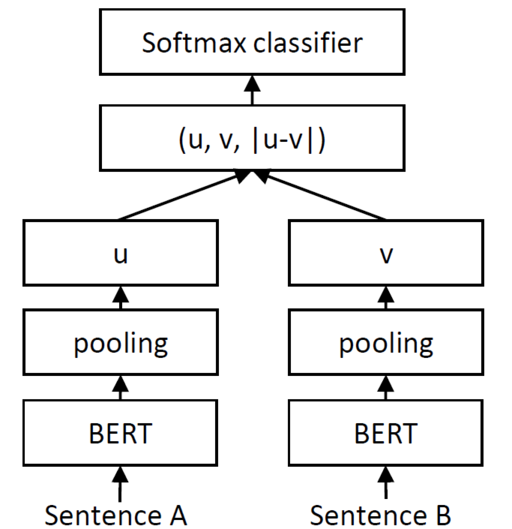

Tasks:

*   **[2 Point]** Prepare a training dataloader and training loop: Read in NLI data, tokenize and generate the corresponding data loader
*   **[2 Point]** BertClassifier: Construct a model that uses above method

**Download NLI dataset**

This dataset includes:
*   Sentence pairs: (sentence1, sentence2)
*   Label: (contradiction, entailment, neutral)
*   Split: train, dev, test

In [ ]:
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

--2023-10-02 14:53:20--  https://sbert.net/datasets/AllNLI.tsv.gz
Resolving sbert.net (sbert.net)... 104.21.67.200, 172.67.180.145, 2606:4700:3036::6815:43c8, ...
Connecting to sbert.net (sbert.net)|104.21.67.200|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz [following]
--2023-10-02 14:53:20--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40794454 (39M) [application/octet-stream]
Saving to: ‘AllNLI.tsv.gz’

AllNLI.tsv.gz       100%[===================>]  38.90M  10.3MB/s    in 3.8s    

2023-10-02 14:53:26 (10

In [ ]:
data = pd.read_csv('AllNLI.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


In [ ]:
def load_nli_dataset(file_name):
  """
  loads the NLI data set
  input: file name
  :return: NLI data set
  """
  data = pd.read_csv('AllNLI.tsv.gz', compression='gzip', delimiter='\t', quoting=csv.QUOTE_NONE)

  label_map = {'entailment': 0, 'contradiction': 1, 'neutral': 2}

  nli_samples = {'train': [{
      'sentence1': row['sentence1'],
      'sentence2': row['sentence2'],
      'label': torch.tensor(label_map[row['label']])
      } for _, row in data.iterrows()

  ]}

  return nli_samples


# A periodic eval on dev test can be added (validation_dataloader)
def train_loop(model, optimizer, train_dataloader, num_epochs, device):
  """
  runs training loop for models
  input: model, optimiser, data loader, number of epocs and the device
  """
  model.to(device)
  model.train()

  for epoch in range(num_epochs):
      epoch_loss = 0.0
      for batch in train_dataloader:
          optimizer.zero_grad()

          input_ids1 = batch['sentence1_tokens'].to(device)
          attention_mask1 = batch['sentence1_attentions'].to(device)
          input_ids2 = batch['sentence2_tokens'].to(device)
          attention_mask2 = batch['sentence2_attentions'].to(device)
          labels = batch['label'].to(device)

          loss, logits = model(input_ids1, attention_mask1, input_ids2, attention_mask2, labels)

          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      average_loss = epoch_loss / len(train_dataloader)
      print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")


class BertClassifier(nn.Module):
    """
    bert classifier model to fine-tune the bert model for better sentence embeddings
    input: bert config and path
    uses a dense layer and softmax activation
    :return: the loss and the logits
    """
    def __init__(self, bert_config, bert_path):
        super(BertClassifier, self).__init__()

        # bert model
        self.bert = Bert(bert_config).load_model(bert_path)

        # pooling and softmax classification
        self.classifier = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.bert.config.hidden_size * 3, num_labels)),
            ('activation', nn.LogSoftmax(dim=1))
        ]))

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, labels=None):

        # creating embeddings
        outputs_a = self.bert(input_ids=input_ids1, attention_mask=attention_mask1)[1]
        outputs_b = self.bert(input_ids=input_ids2, attention_mask=attention_mask2)[1]

        # these are going to be the inputs for the classification
        u = outputs_a
        v = outputs_b

        # combining the vectors and their difference
        combined = torch.cat((u, v, torch.abs(u - v)), dim=1)
        logits = self.classifier(combined)

        # finding the loss
        loss = None
        if labels is not None:
            loss_fn = nn.NLLLoss()
            loss = loss_fn(logits, labels)

        return (loss, logits) if loss is not None else logits

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

#TODO: Create a BertClassifier with required parameters
###    Replace None with required input based on yor implementation
bert_classifier = BertClassifier(bert_config, bert_path)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier, optimizer, train_dataloader, num_epochs, device)

Epoch 1/3, Loss: 0.9651
Epoch 2/3, Loss: 0.8223
Epoch 3/3, Loss: 0.7624


**Evaluation**

Expected result:

Pearson correlation: 0.37

Spearman correlation: 0.42

In [ ]:
#TODO: run evaluation loop
result_from_classification = eval_loop(bert_classifier.bert, test_dataloader, device, 'bert_classifier')
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')


Pearson correlation: 0.41
Spearman correlation: 0.45


# **Coding Challenge Part 4: Learning sentence embedding using a contrastive approach based on NLI dataset [3 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

In this part, you are asked to explore another method that leverages a contrastive approach using NLI dataset.

Tasks **[3 Points]** :

*   Generate a dataloader if this is required for your approach
*   Construct a BERT based model using a contrastive method

In [ ]:
 #TODO: add code to load NLI dataset in required format
 ###    if load_nli_dataset(..) is not appropriate for your method
def load_contrastive_nli_dataset(file_name):
    #TODO: add code to load NLI dataset in required format
    data = pd.read_csv('AllNLI.tsv.gz', compression='gzip', delimiter='\t', quoting=csv.QUOTE_NONE)

    # change labels to fit the contrastive approach
    label_map = {'entailment': 1, 'contradiction': 0, 'neutral': 0}


    nli_samples = {'train': [{
        'sentence1': row['sentence1'],
        'sentence2': row['sentence2'],
        'label': torch.tensor(label_map[row['label']], dtype=torch.float)
      } for _, row in data.iterrows()

    ]}


    return nli_samples

class BertContrastive(nn.Module):
    """
    bert based model to fine-tune the bert model for better sentence embeddings
    input: bert config and path
    calculates the sentence similarities using cosine sim, and calculated the contrastive loss
    :return: the loss and the logits
    """
    def __init__(self, bert_config, bert_path, margin=0.5):
        super(BertContrastive, self).__init__()
        self.bert = Bert(bert_config).load_model(bert_path)

        self.margin = margin  # Margin for the contrastive loss

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, labels=None):

        # finding the embeddings
        outputs_a = self.bert(input_ids=input_ids1, attention_mask=attention_mask1)[1]
        outputs_b = self.bert(input_ids=input_ids2, attention_mask=attention_mask2)[1]

        # finding the distances between the embeddings
        distances = cosine_sim(outputs_a, outputs_b)

        # calculate contrastive loss
        losses = 0.5 * (labels.float() * distances.pow(2) +
                       (1 - labels).float() * F.relu(self.margin - distances).pow(2))
        return losses.mean(), None   # return the mean loss

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
train_batch_size = 8
num_labels =3
hidden_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_contrastive_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size)

#TODO: Create a BertContrastive with required parameters
###    Replace None with required input based on yor implementation
bert_contrastive = BertContrastive(bert_config, bert_path)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
train_loop(bert_contrastive, optimizer, train_dataloader, num_epochs, device)

Epoch 1/3, Loss: 0.0346
Epoch 2/3, Loss: 0.0296
Epoch 3/3, Loss: 0.0272


**Evaluation**

In [ ]:
#TODO: run evaluation loop
result_from_contrastive = eval_loop(bert_contrastive.bert, test_dataloader, device, 'bert_contrastive')
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')


Pearson correlation: 0.27
Spearman correlation: 0.28


# **Coding Challenge Part 5: Comparison [1 Point]**

In the final part of the coding challenge, you are asked to compare the result of pretrained BERT, classification based BERT, and contrastive method based BERT.

These are the tasks **[1 Point]**:


*   Plot the result for each model
*   Explain the difference between methods and their impact on the result and comparison

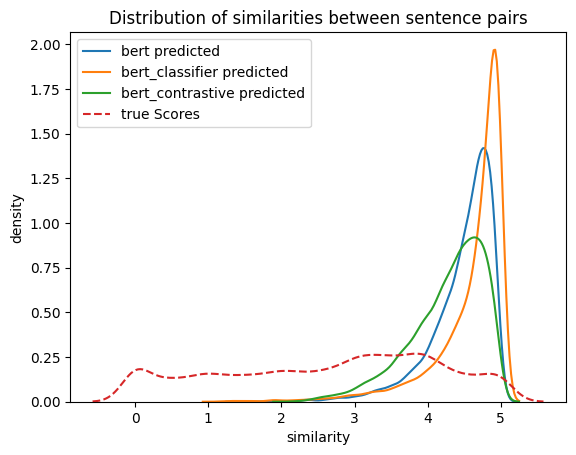

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# define model names
model_names = ['bert', 'bert_classifier', 'bert_contrastive']
true_scores_all = []  # to store the true scores from each model's file


# plot predicted similarities
for model_name in model_names:
    with open(f"{model_name}_similarities.csv", mode='r') as file:
        reader = csv.DictReader(file)

        normalized_similarities = []
        true_scores = []
        for row in reader:
            similarity = float(row["Similarity"])
            true_score = float(row["True_Score"])

            normalized_similarity = (similarity + 1) * 2.5  # normalize to the range [0, 5]
            normalized_similarities.append(normalized_similarity)
            true_scores.append(true_score)

        true_scores_all.extend(true_scores)  # add true scores to the list

        sns.kdeplot(normalized_similarities, label=f"{model_name} predicted")

# plot true similarities
sns.kdeplot(true_scores_all, label='true Scores', linestyle='dashed')

plt.legend()
plt.title('Distribution of similarities between sentence pairs')
plt.xlabel('similarity')
plt.ylabel('density')
plt.show()


The distribution of all sentence embeddings models seem to be biased towards similar sentences. Compared to the original BERT model, the model using softmax classifying is more biased, whereas the contrastive approach model is less biased towards higher similarity scores. Also, the distribution of the true scores are plotted as well to compare the predicted ones.

It seems that even though the softmax classifier method does better on the Pearson and Spearman correlation tests, it does so because it simply rates everything to be similar.

# **[OPTIONAL] Explore an alternative way to improve sentence encoder in terms of *performance* or *efficiency* [6 Points]**

Potential directions:
*   Improve the methodology to compute higher quality sentence embeddings  
*   Improve the efficiency during fine-tuning in terms of memory or training time
*   Use different machine learning methods that leverages other resources such as auxillary/teacher models
*   Use different datasets with other training objectives


**You can use any additional model, dataset, library or package for this part!!**

#Improve fine-tuning with more training (increase number of epochs)


In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 10                                                                         # increase number of epochs from 3 to 10
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')
#nli_dataset
#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)
#tokenized_train
#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

#TODO: Create a BertClassifier with required parameters
###    Replace None with required input based on yor implementation
bert_classifier = BertClassifier(bert_config, bert_path)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier, optimizer, train_dataloader, num_epochs, device)

Epoch 1/10, Loss: 0.9561
Epoch 2/10, Loss: 0.8224
Epoch 3/10, Loss: 0.7584
Epoch 4/10, Loss: 0.7104
Epoch 5/10, Loss: 0.6703
Epoch 6/10, Loss: 0.6358
Epoch 7/10, Loss: 0.6069
Epoch 8/10, Loss: 0.5793
Epoch 9/10, Loss: 0.5520
Epoch 10/10, Loss: 0.5261


In [ ]:
result_from_classification = eval_loop(bert_classifier.bert, test_dataloader, device, 'bert_classifier2')
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')


Pearson correlation: 0.43
Spearman correlation: 0.46


#Improve methodology: BertClassifier with (u,v,|u-v|, u*v)

In [ ]:
class BertClassifierPlus(nn.Module):
    """
    bert classifier plus model to fine-tune the bert model for better sentence embeddings
    input: bert config and path
    uses a dense layer and softmax activation
    :return: the loss and the logits
    """
    def __init__(self, bert_config, bert_path):
        super(BertClassifierPlus, self).__init__()

        # bert model
        self.bert = Bert(bert_config).load_model(bert_path)

        # pooling and softmax classification
        self.classifier = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.bert.config.hidden_size * 4, num_labels)),
            ('activation', nn.LogSoftmax(dim=1))
        ]))

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, labels=None):

        # creating embeddings
        outputs_a = self.bert(input_ids=input_ids1, attention_mask=attention_mask1)[1]
        outputs_b = self.bert(input_ids=input_ids2, attention_mask=attention_mask2)[1]

        # these are going to be the inputs for the classification
        u = outputs_a
        v = outputs_b

        # combining the vectors and their difference
        combined = torch.cat((u, v, torch.abs(u - v), u*v), dim=1)
        logits = self.classifier(combined)

        # finding the loss
        loss = None
        if labels is not None:
            loss_fn = nn.NLLLoss()
            loss = loss_fn(logits, labels)

        return (loss, logits) if loss is not None else logits

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

#TODO: Create a BertClassifier with required parameters
###    Replace None with required input based on yor implementation
bert_classifier_plus = BertClassifierPlus(bert_config, bert_path)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier_plus, optimizer, train_dataloader, num_epochs, device)

Epoch 1/3, Loss: 1.1304
Epoch 2/3, Loss: 1.1289
Epoch 3/3, Loss: 1.1279


In [ ]:
result_from_classification = eval_loop(bert_classifier_plus.bert, test_dataloader, device, 'bert_classifier_plus')
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')


Pearson correlation: 0.26
Spearman correlation: 0.30


#Try different methodology: using Sentence Transformer library

Here I wanted to import the Sentence Transform Library to use that to create a better sentence embedder, but I ran out of time.

#Use other data sets

Here I wanted to import other NLI data sets, but ran out of time.

#Plotting how the improvements changed distributions

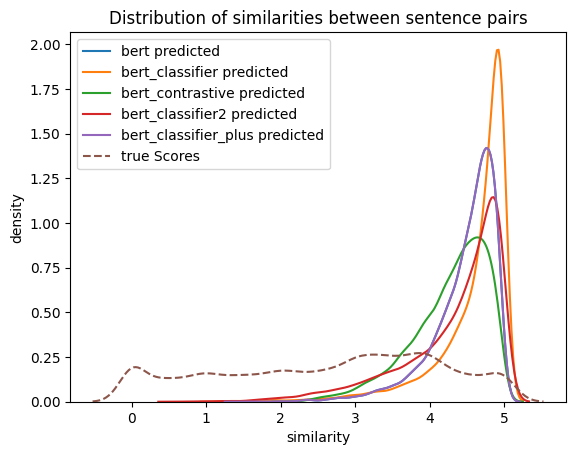

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# define model names
model_names = ['bert', 'bert_classifier', 'bert_contrastive', 'bert_classifier2', 'bert_classifier_plus']
true_scores_all = []  # to store the true scores from each model's file


# plot predicted similarities
for model_name in model_names:
    with open(f"{model_name}_similarities.csv", mode='r') as file:
        reader = csv.DictReader(file)

        normalized_similarities = []
        true_scores = []
        for row in reader:
            similarity = float(row["Similarity"])
            true_score = float(row["True_Score"])

            normalized_similarity = (similarity + 1) * 2.5  # normalize to the range [0, 5]
            normalized_similarities.append(normalized_similarity)
            true_scores.append(true_score)

        true_scores_all.extend(true_scores)  # add true scores to the list

        sns.kdeplot(normalized_similarities, label=f"{model_name} predicted")

# plot true similarities
sns.kdeplot(true_scores_all, label='true Scores', linestyle='dashed')

plt.legend()
plt.title('Distribution of similarities between sentence pairs')
plt.xlabel('similarity')
plt.ylabel('density')
plt.show()